In [85]:
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cv2
import imagehash
import json
from PIL import Image
from tqdm import tqdm
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strings must be of equal length.")

    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))





In [86]:
def read_json(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

def recommend_5(query_path, data_json, distance_measure = "hamming"):
    diff_list = {}
    result = []
    for i in data_json.keys():
        if distance_measure == "hamming":
            diff_list[i] = hamming_distance(data_json[query_path], data_json[i])
        elif distance_measure == "cos":
            A, B = np.array(data_json[query_path]), np.array(data_json[i])
            dot_product = np.dot(A, B)
            norm_A = np.linalg.norm(A)
            norm_B = np.linalg.norm(B)
            
            cosine_similarity = dot_product / (norm_A * norm_B)
    
            diff_list[i] = cosine_similarity
        elif distance_measure == "l2":
            diff_list[i] = np.linalg.norm(np.array(data_json[query_path])-np.array(data_json[i]))

    top_5_recommend = sorted(diff_list.items(), key=lambda x: x[1], reverse=False)
    y_cat = query_path.split('/')[-2]
    diff_uniq = [diff_value for diff_value in sorted(set(dict(top_5_recommend).values()), reverse=False)]
    # print([tup[1] for tup in top_5_recommend])
    # print(diff_uniq)
    for diff_value in diff_uniq:
        if len(result)>=10:
            break
        min_unique = []
        for tup in top_5_recommend:
            if tup[1]>=diff_value:
                min_unique.append((tup[0], tup[1]))

        for tup in min_unique:
            if y_cat in tup[0]:
                if len(result)>=10:
                    break
                result.append(tup)
                
        for tup in min_unique:
                if len(result)>=10:
                        break
                result.append(tup)
                

       
            
    #print(len(result))
    return result[:10]
    # return top_5_recommend[:10]

def precision_at_K(query_image_path, top_5_recommend):
    y_cat = np.array([query_image_path.split('/')[-2]]*10)
    # y_cat = np.array(['cardigans']*5)
    y_pred = np.array([cat[0].split('/')[-2] for cat in top_5_recommend])
    comparison_array = (y_cat == y_pred)
    true_positives = np.sum(comparison_array)
    #print(y_cat, y_pred,comparison_array, true_positives, true_positives/(true_positives+  len(comparison_array)-true_positives))
    return true_positives/(true_positives+  len(comparison_array)-true_positives)


def evaluate(data_json, distance="hamming"):
    total_acc = 0
    for k in tqdm(data_json.keys()):
        top_5 = recommend_5(k, data_json, distance)
        acc = precision_at_K(k, top_5)
        total_acc += acc
        
        
    return total_acc/len(data_json)


In [87]:
data_dhash = read_json('/space/hotel/hieud/mlflow_aisia/latent_features_dhash_test.json')
dhash_acc =evaluate(data_dhash,distance="hamming")
dhash_acc

100%|██████████| 243/243 [00:00<00:00, 895.00it/s]


0.3292181069958848

In [88]:
data_tsne = read_json('/space/hotel/hieud/mlflow_aisia/latent_features_tsne_test.json')
tsne_acc = evaluate(data_tsne,distance="l2")
tsne_acc

100%|██████████| 243/243 [00:00<00:00, 681.69it/s]


0.285185185185185

In [89]:
data_deep = read_json('/space/hotel/hieud/mlflow_aisia/latent_features_deep_learning_test.json')
for k in data_deep.keys():
    exp_z = np.exp(data_deep[k] - np.max(data_deep[k]))  # Subtracting max(z) for numerical stability

    data_deep[k] = exp_z / exp_z.sum(axis=0)
# print(data_deep.values())
deep_acc = evaluate(data_deep,distance="l2")
print(deep_acc)


100%|██████████| 243/243 [00:00<00:00, 680.97it/s]

0.1728395061728397


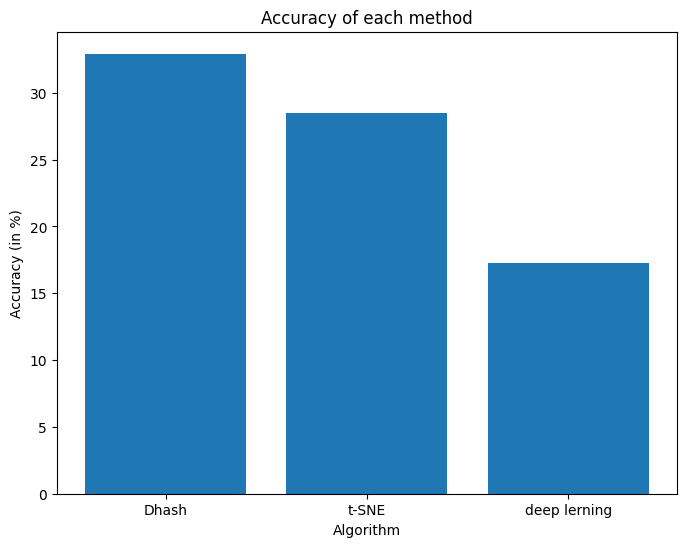

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Dhash', 't-SNE', 'deep lerning']
values = [dhash_acc*100, tsne_acc*100, deep_acc*100]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values)

# Add labels and title
plt.xlabel('Algorithm')
plt.ylabel('Accuracy (in %)')
plt.title('Accuracy of each method')
plt.savefig('result.png')
# Display the plot
plt.show()

In [91]:
deep_acc

0.1728395061728397